# Data Pipeline
Initial data analysis pipeline including a naive sentiment analysis using TextBlob.

In [1]:
import re
import html
import spacy
import textacy
from textblob import TextBlob
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
# Plot using Pandas datatime objects
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
rc_fonts = {'figure.figsize': (15, 8),
            'axes.labelsize': 20,
            'xtick.labelsize': 16,
            'ytick.labelsize': 16}
plt.rcParams.update(rc_fonts)
plt.style.use('ggplot')
%matplotlib inline

## Use ```spaCy``` for tokenization and sentence segmentation

In [3]:
import spacy
from spacy import displacy
# Load spaCy language model (blank model to which we add pipeline components)
sentencizer = spacy.blank('en')
sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))

#### Specify named entity of interest

In [4]:
name = "Ryan Lochte"

In [5]:
datafile = 'all_the_news_v2.csv'
datapath = Path('../') / 'data' / datafile 
colnames = ['title', 'author', 'date', 'content', 'year', 'month', 'publication', 'length']

news = pd.read_csv(datapath, usecols=colnames, parse_dates=['date'])
news['author'] = news['author'].str.strip()
news.head()

,title,author,date,content,year,month,publication,length
0,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,2017-05-31,And never more so than in Showtime’s new...,2017.0,5.0,Verge,2376
1,"AI, the humanity!",Sam Byford,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017.0,5.0,Verge,2125
2,The Viral Machine,Kaitlyn Tiffany,2017-05-25,Super Deluxe built a weird internet empi...,2017.0,5.0,Verge,3310
3,How Anker is beating Apple and Samsung at thei...,Nick Statt,2017-05-22,Steven Yang quit his job at Google in th...,2017.0,5.0,Verge,3632
4,Tour Black Panther’s reimagined homeland with ...,Kwame Opam,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017.0,5.0,Verge,262


In [6]:
news = news.dropna(subset=['date', 'title'])
news.shape[0]

143156

### Filter articles based on name match
In this section we only select those news articles that contain part of or all of the name we input as ```name```.

In [7]:
def check_name(content, name):
    flag = False
    if name in content:
        flag = True
    return flag

def filter_df(df):
    df['match'] = df['content'].apply(lambda x: check_name(x, name))
    df_relevant = df.loc[df['match'].eq(True)]
    return df_relevant.drop(['match'], axis=1)

news_relevant = filter_df(news)
print(news_relevant.shape[0])
news_relevant.head()

182


,title,author,date,content,year,month,publication,length
3095,"After Olympic-sized goof, Ryan Lochte begins a...",David Wharton,2017-04-27,Don’t cringe or shake your head or stop readin...,2017.0,4.0,Los Angeles Times,1925
8946,Michael Phelps is a touch off in 100 butterfly...,Everett Cook,2014-08-08,Michael Phelps\' bid for his most important wi...,2014.0,8.0,Los Angeles Times,996
13789,Michael Phelps Powers U.S. to Victory in 4x100...,"Victor Mather, Karen Crouse and Doug Mills",2016-08-10,RIO DE JANEIRO — Michael Phelps won his 19th O...,2016.0,8.0,New York Times,276
13825,Rio Olympics: Simone Manuel Makes History in t...,Karen Crouse,2016-08-16,RIO DE JANEIRO — Simone Manuel managed to make...,2016.0,8.0,New York Times,1468
13839,"Rio Olympics: A Phelps Upset, a Judo Snub, and...",Sam Manchester and Victor Mather,2016-08-16,Katie Ledecky did what Katie Ledecky does best...,2016.0,8.0,New York Times,1614


### Perform sentence segmentation
Store the sentences in each news articles as a list of sentences, from which we can easily extract per-sentence sentiment.

In [8]:
def get_relevant(text, name):
    doc = sentencizer(text)
    relevant = []
    for sent in doc.sents:
        for n in name.split():
            if n in sent.text:
                relevant.append(sent.text.strip())
    # Remove duplicates
    relevant = list(dict.fromkeys(relevant))
    return relevant

In [9]:
news_relevant['relevant'] = news_relevant['content'].apply(lambda x: get_relevant(x, name))

In [10]:
for i in news_relevant['relevant'][:5]:
    print(i, '\n--')

["That’s all Ryan Lochte wants as he ambles across the pool deck on a bright Southern California day, looking tanned and relaxed, if a bit weary from his morning workout.', '“", 'Lochte now finds himself living in Los Angeles with his pregnant fiancée and training at USC with thoughts of a comeback.', "Here’s the condensed version:', 'After a fifth-place finish in the 200-meter individual medley — his dissatisfaction hardly assuaged by a gold in the 800 freestyle relay — Lochte partied with three teammates at the French team’s hospitality house.', '", "Lochte initially told authorities they were pulled over and robbed by armed men posing as police officers.', '", "Lochte suffered an additional blow as Speedo and other corporate sponsors walked away.', '", 'Ryan Lochte didn’t have to get drunk and vandalize a Rio de Janeiro gas station during the Summer Olympics in August.', "But he did, and it’s at times like this when people really need their...', 'Ryan Lochte didn’t have to get drunk

### Naive sentiment scoring using TextBlob

In [11]:
def get_score_textblob(text_list):
    # Calculate polarity for each sentence
    sentiment_list = [round(TextBlob(text).sentiment.polarity, 4) for text in text_list]
    score = np.median(sentiment_list)
    deviation = np.std(sentiment_list)
    return score, deviation

In [12]:
news_relevant['score'], news_relevant['deviation'] = zip(*news_relevant['relevant'].map(get_score_textblob))
news_relevant.head(3)

,title,author,date,content,year,month,publication,length,relevant,score,deviation
3095,"After Olympic-sized goof, Ryan Lochte begins a...",David Wharton,2017-04-27,Don’t cringe or shake your head or stop readin...,2017.0,4.0,Los Angeles Times,1925,[That’s all Ryan Lochte wants as he ambles acr...,0.00,0.213016
8946,Michael Phelps is a touch off in 100 butterfly...,Everett Cook,2014-08-08,Michael Phelps\' bid for his most important wi...,2014.0,8.0,Los Angeles Times,996,"[Ryan Lochte, another preeminent American swim...",0.00,0.000000
13789,Michael Phelps Powers U.S. to Victory in 4x100...,"Victor Mather, Karen Crouse and Doug Mills",2016-08-10,RIO DE JANEIRO — Michael Phelps won his 19th O...,2016.0,8.0,New York Times,276,[Ryan Held and Nathan Adrian brought the U.S. ...,0.45,0.050000


#### Positive sentiment group

In [13]:
pos = news_relevant.sort_values(by=['score'], ascending=False).reset_index(drop=True)
pos.iloc[:5, :].head(3)

,title,author,date,content,year,month,publication,length,relevant,score,deviation
0,"Hey, Watch This",Kevin D. Williamson,2016-08-07,"[‘Hey, Dad, watch this!” Here is a scene that ...",2016.0,8.0,National Review,1226,[Ryan Lochte and America’s Man-Boy ProblemAmer...,0.75,0.000000
1,Can Ryan Lochte Redeem Himself on Dancing With...,Megan Garber,2016-08-24,[ For us to continue writing great stor...,2016.0,8.0,Atlantic,1358,"[Rumor has it that, now, another celebrity wil...",0.70,0.367423
2,The Rio Olympics: Catch the Fever!,Jim Geraghty,2016-08-05,[The International Olympic Committee wanted to...,2016.0,8.0,National Review,1217,[Ryan Lochte and America’s Man-Boy ProblemAmer...,0.65,0.000000


#### Negative sentiment group

In [14]:
neg = news_relevant.sort_values(by=['score']).reset_index(drop=True)
neg.iloc[:5, :].head(3)

,title,author,date,content,year,month,publication,length,relevant,score,deviation
0,"2016 Gave Us 262,800 'Two Minutes Hates.' Some...",Daniel J. Flynn,2016-12-30,Andy Warhol envisioned a future in which every...,2016.0,12.0,Breitbart,787,[Ryan Lochte suffered a terrible hangover in 2...,-1.0000,0.0
1,‘This Only Confirms the Image of the U.S.A.’ -...,Lela Moore and Lindsey Underwood,2016-08-22,Here are the top 10 comments of the week on ou...,2016.0,8.0,New York Times,1596,"[Jose in Rio de Janeiro, reacting to an articl...",-0.2000,0.0
2,'Bayou Billionaire' star Valerie Wells dead in...,NaN,2016-11-09,"[According to People, the Shreveport, Louisian...",2016.0,11.0,Fox News,265,"[Playboy model in hot water, Hailey Baldwin st...",-0.1923,0.0


In [15]:
#### 

In [16]:
mixed = news_relevant.sort_values(by=['deviation'], ascending=False).reset_index(drop=True)
mixed.iloc[:5, :].head(3)

,title,author,date,content,year,month,publication,length,relevant,score,deviation
0,Can Ryan Lochte Redeem Himself on Dancing With...,Megan Garber,2016-08-24,[ For us to continue writing great stor...,2016.0,8.0,Atlantic,1358,"[Rumor has it that, now, another celebrity wil...",0.7,0.367423
1,Roundup: Smart Thoughts On Ryan Lochte And Whi...,Leah Donnella,2016-08-19,"[This week, in a tale of Olympic scandal and i...",2016.0,8.0,NPR,1495,"[[This week, in a tale of Olympic scandal and ...",0.0,0.356279
2,Ryan Lochte 'in talks' to join 'Dancing With T...,Chloe Melas,2016-08-24,[ (CNN)Ryan Lochte might be ditching his speed...,2016.0,8.0,CNN,168,[[ (CNN)Ryan Lochte might be ditching his spee...,0.2,0.339935


### Highlight relevant named entities using ```spaCy```

In [17]:
# Load full spaCy language model for NER
nlp = spacy.load('en_core_web_md')

In [18]:
from IPython.display import Markdown, display
options = {'ents': ['PERSON', 'ORG', 'GPE', 'EVENT'], 
           'colors': {'PERSON': '#9fafe5', 'ORG': '#d59b9b', 'GPE':'#81cba6'}}
def printmd(string):
    display(Markdown(string))
    
def display_entities(df, max_entries=5):
    # Set relevant named entities that we want to extract
    for idx, sent in enumerate(df['relevant'].str.join(' ')[:max_entries]):
        doc = nlp(sent)
        printmd('**{}**'.format(df['title'][idx]))
        displacy.render(doc, style='ent', jupyter=True, options=options)
        print('\n')
        
def vis(pos, neg, mixed):
    # Visualize positive and negativ groups using markdown
    printmd('<font color=green>**Positive**</font>')
    display_entities(pos)
    printmd('<font color=red>**Negative**</font>')
    display_entities(neg)
    printmd('<font color=yellow>**Mixed**</font>')
    display_entities(mixed)

In [19]:
vis(pos, neg, mixed)

<font color=green>**Positive**</font>

**Hey, Watch This**

**Can Ryan Lochte Redeem Himself on Dancing With the Stars? **

**The Rio Olympics: Catch the Fever!**

**How to train like an Olympian – eat loads of peanut butter and listen to robots**

**Will Alicia Machado join ‘Dancing with the Stars’ next season?**

<font color=red>**Negative**</font>

**2016 Gave Us 262,800 'Two Minutes Hates.' Some Lasted Longer Than Others. - Breitbart**

**‘This Only Confirms the Image of the U.S.A.’ - The New York Times**

**'Bayou Billionaire' star Valerie Wells dead in murder-suicide, reports say**

**Stars urge their fans to 'fight' after Trump win**

**Michael Moore to Democrats: I told you Trump was going to win**

<font color=yellow>**Mixed**</font>

**Can Ryan Lochte Redeem Himself on Dancing With the Stars? **

**Roundup: Smart Thoughts On Ryan Lochte And White Privilege**

**Ryan Lochte 'in talks' to join 'Dancing With The Stars'**

**U.S. swimmers' tall tale touches a raw nerve in Brazil**

**Ryan Lochte, ’12 Olympic Champion, Misses Rio Cut in 400 I.M. - The New York Times**

## Visualization

### Plot sentiment score and magnitude versus time of publishing of the article
In this section, sentiment "score" is the median of all polarity values (positive or negative) obtained per-sentence of the article from TextBlob. Sentiment "magnitude" is the standard deviation of sentiment among the per-sentence polarity values. 

In [20]:
pos_avg_score = pos.groupby('date')['score'].mean()
pos_avg_mag = pos.groupby('date')['deviation'].mean()

#### Concatenate scores and magnitudes for plotting

In [21]:
scores = pd.concat((pos_avg_score, pos_avg_mag), axis=1).sort_values(by=['date'])
scores.to_csv('test.csv', header=True)
scores.head()

,score,deviation
date,,
2014-08-08,0.000,0.000000
2016-06-27,0.000,0.315103
2016-08-05,0.325,0.000000
2016-08-06,0.250,0.000000
2016-08-07,0.750,0.000000


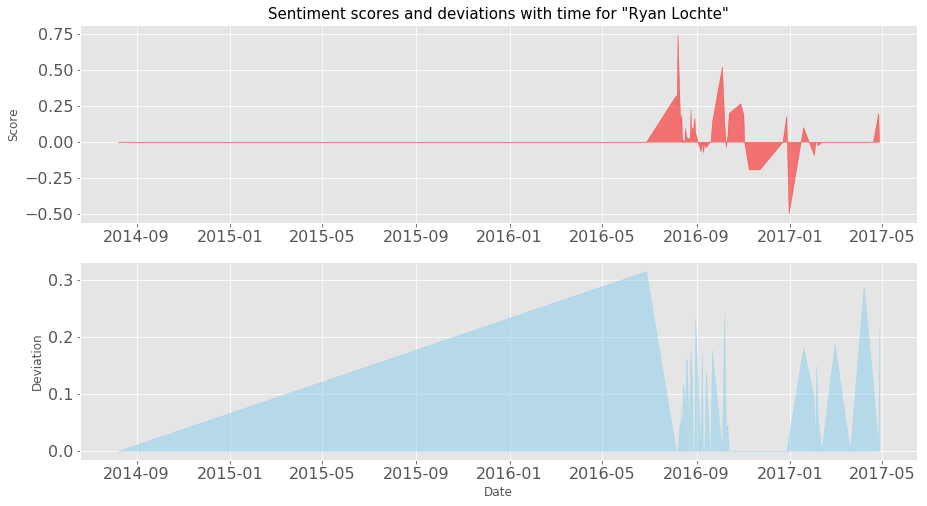

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.fill_between(scores.index, scores['score'], color='red', alpha=0.5);
ax1.set_ylabel('Score');
ax1.set_title('Sentiment scores and deviations with time for "{}"'.format(name), size=15);
ax2.fill_between(scores.index, scores['deviation'], color='skyblue', alpha=0.5);
ax2.set_ylabel('Deviation');
ax2.set_xlabel('Date');
plt.savefig("{}_scores".format('_'.join(name.split()).lower()))

#### Get counts of positive and negative mentions based on Publication

In [23]:
grouped = news_relevant.groupby('publication').apply(lambda x: x['score'] >= 0.0)
grouped = grouped.groupby('publication').value_counts().to_frame()
grouped = grouped.unstack().fillna(0.0)
grouped.columns = ['Negative', 'Positive']
grouped = grouped.sort_values(by='Negative')
grouped

,Negative,Positive
publication,,
Business Insider,0.0,6.0
Los Angeles Times,0.0,2.0
National Review,0.0,8.0
New York Post,0.0,12.0
Reuters,0.0,4.0
Atlantic,1.0,22.0
Breitbart,2.0,5.0
Buzzfeed News,2.0,9.0
CNN,3.0,17.0


#### Plot article breakdown

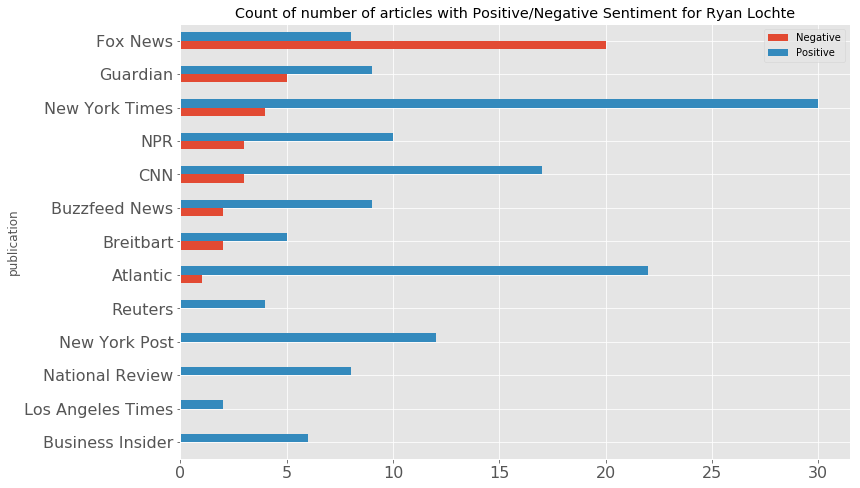

In [24]:
grouped.plot(kind='barh', figsize=(12, 8));
plt.title('Count of number of articles with Positive/Negative Sentiment for {}'.format(name));
plt.savefig("{}_breakdown".format('_'.join(name.split()).lower()))

#### Output result to CSV

In [25]:
out_filename = '_'.join(name.split()).lower() + '.csv'
out_path = Path('../') / "modules/results" / out_filename
grouped.to_csv(out_path, index=False, header=True)

## Visualize Cosine Similarity Distances
To see how similar or different each article is based on publication, we can compute the cosine distances between articles to generate a "distance matrix" and then visualize these distances in two-dimensional space.

In [26]:
import seaborn as sns
from string import punctuation

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS

In [27]:
add_removed_words = {n.lower() for n in name.split()}
# Include specific words to be removed
stopwords = nlp.Defaults.stop_words
stopwords = stopwords.union(add_removed_words)

In [28]:
# Tokenize and lemmatize text
def word_tokenize(text):
    doc = sentencizer(text)
    tokens = [str(tok.lemma_).lower() for tok in doc if tok.text not in stopwords \
              and tok.text not in punctuation]
    return tokens

In [29]:
news_relevant['lemmatized'] = news_relevant['relevant'].str.join(' ').apply(word_tokenize).str.join(' ')
news_relevant.head()

,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmatized
3095,"After Olympic-sized goof, Ryan Lochte begins a...",David Wharton,2017-04-27,Don’t cringe or shake your head or stop readin...,2017.0,4.0,Los Angeles Times,1925,[That’s all Ryan Lochte wants as he ambles acr...,0.00000,0.213016,that ’s ryan lochte want amble pool deck brigh...
8946,Michael Phelps is a touch off in 100 butterfly...,Everett Cook,2014-08-08,Michael Phelps\' bid for his most important wi...,2014.0,8.0,Los Angeles Times,996,"[Ryan Lochte, another preeminent American swim...",0.00000,0.000000,ryan lochte preeminent american swimmer finish...
13789,Michael Phelps Powers U.S. to Victory in 4x100...,"Victor Mather, Karen Crouse and Doug Mills",2016-08-10,RIO DE JANEIRO — Michael Phelps won his 19th O...,2016.0,8.0,New York Times,276,[Ryan Held and Nathan Adrian brought the U.S. ...,0.45000,0.050000,ryan held nathan adrian bring u.s. home adrian...
13825,Rio Olympics: Simone Manuel Makes History in t...,Karen Crouse,2016-08-16,RIO DE JANEIRO — Simone Manuel managed to make...,2016.0,8.0,New York Times,1468,[Michael Phelps won the 200 individual medley ...,0.05415,0.054150,michael phelps win 200 individual medley easil...
13839,"Rio Olympics: A Phelps Upset, a Judo Snub, and...",Sam Manchester and Victor Mather,2016-08-16,Katie Ledecky did what Katie Ledecky does best...,2016.0,8.0,New York Times,1614,[Phelps Breaks an Ancient Record: Michael Phel...,0.05415,0.054150,phelps breaks ancient record michael phelps wi...


#### Calculate TF-IDF for document similarity
We first define the term frequency-inverse document frequency to vectorize the text for each article into parameters, and generate a ```tf-idf``` matrix. 

Once we compute the ```tf-idf``` matrix, we can find a "distance matrix" that stores how similar or how different two documents are.

In [30]:
# Define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2)
# 
tfidf_matrix = tfidf_vectorizer.fit_transform(news_relevant['lemmatized'] ) #fit the vectorizer to synopses
print(tfidf_matrix.shape)

# Display some key terms
terms = tfidf_vectorizer.get_feature_names()

(182, 33)


In [31]:
# Get cosine distance matrix
dist = 1 - cosine_similarity(tfidf_matrix)

#### Multidimensional Scaling (MDS)
The computed distances are in multi-dimensional in nature. To visualize the similarity, we "embed" the cosine distances (from the distance matrix) to a two-dimensional space, which we can then plot to see how the articles compare with each other in terms of their content.

In [32]:
embedding = MDS(n_components=2, dissimilarity="precomputed", random_state=37)
dist_transformed = embedding.fit_transform(dist)
print(dist_transformed.shape)

xs, ys = dist_transformed[:, 0], dist_transformed[:, 1]

(182, 2)


#### Generate an MDS DataFrame for plotting
We combine the x-y distances from the MDS calculation with the original publication labels to see how different the articles are from each other, colored by publication.

In [33]:
compare = pd.DataFrame(dict(label=news_relevant['publication'], x=xs, y=ys))
compare.head()

,label,x,y
3095,Los Angeles Times,-0.041857,0.128095
8946,Los Angeles Times,0.088965,0.515306
13789,New York Times,0.585855,0.291918
13825,New York Times,-0.712049,-0.349074
13839,New York Times,-0.712049,-0.349074


In [34]:
L = news_relevant['publication'].nunique()
print("Found {} unique categories for publications".format(L))

Found 13 unique categories for publications


#### Visualize similarities as embedded cosine distances

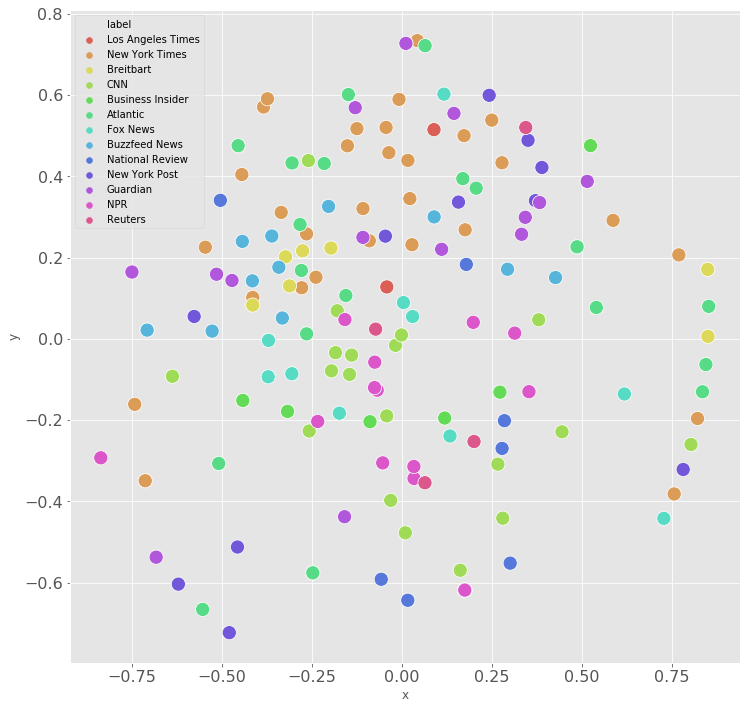

In [35]:
plt.figure(figsize=(12, 12))
sns.scatterplot(x='x', y='y', data=compare, hue='label',
               s=200, palette=sns.color_palette("hls", 13));
plt.legend(loc='best');